In [69]:
# Import all modules for exploratory data analysis

# Extract and save data from database
import db_utils as dbu
# Change datatype of columns to the appripriate ones
import pre_processing as prep
# Get descritve informarion from the dataframe
import extract_info as extract 
# Creates plots for data
import plot as plo
import pandas as pd
import numpy as np
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm




In [2]:
# Extract cloud database credentials from yaml file
db_credentials = dbu.read_credentials("/Users/ChAre/OneDrive/Desktop/aicore/EDA_finance/credentials.yaml")

# Extracting the data from Amazon RDS

In [3]:
# Initialise RDSDatabaseConnector class
db_connector = dbu.RDSDatabaseConnector(db_credentials)

In [4]:
# Connect to database and extract desire database in the cloud
# RDSDatabaseConnector.save_data() call upon: extract_data, 
#db_connector.save_data()

In [5]:
# Load data into pyhton
df_unclean = db_connector.load_data("./loan_payments")

# Data preprocessing

In [6]:
# Inspect the columns data types
df_unclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

In [7]:
# Create instance of preprocessing of DataTransform class for preprocessing.
df_prep = prep.DataTransform(df_unclean)

In [8]:
# Transform columns into the categorical data type
df_prep.category_transform(["grade", "sub_grade", "home_ownership", "verification_status", "loan_status", "payment_plan", "purpose", "application_type", "employment_length", "policy_code"])

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.00,0.00,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.00,0.00,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.00,0.00,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.00,0.00,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.00,0.00,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36 months,9.01,159.03,B,B2,...,0.00,0.00,Jul-2016,160.61,NaN,Jul-2016,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36 months,10.59,162.73,C,C2,...,0.00,0.00,Oct-2016,490.01,NaN,Sep-2016,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36 months,7.43,108.77,A,A2,...,0.00,0.00,Sep-2016,110.58,Sep-2016,May-2013,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36 months,7.43,155.38,A,A2,...,0.00,0.00,Mar-2014,0.00,NaN,May-2013,NaN,NaN,1,INDIVIDUAL


In [9]:
# Convert columns to date type data
df_prep.date_transform(["issue_date", "earliest_credit_line", "last_payment_date", "next_payment_date", "last_credit_pull_date"])

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36 months,9.01,159.03,B,B2,...,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36 months,10.59,162.73,C,C2,...,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36 months,7.43,108.77,A,A2,...,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36 months,7.43,155.38,A,A2,...,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,NaN,1,INDIVIDUAL


In [10]:
# Preporcess term column

# Convert column values into strings
df_prep.string_transform(["term"])

# Remove unwanted characters from the column values
df_prep.remove_characters("term", ["months"])

# Transform column values to numeric
df_prep.numeric_transform(["term"])

#Rename column to reflect the unit for the values
df_prep.rename_column("term", "term_in_months")

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,NaN,1,INDIVIDUAL


In [11]:
# Create DataFrameInfo instance to extract useful information from the dataframe.
df_inf = extract.DataFrameInfo(df_prep.dataframe)

In [12]:
# Check the data types of the columns after the transformations.
df_inf.check_columns_type()

id                                      int64
member_id                               int64
loan_amount                             int64
funded_amount                         float64
funded_amount_inv                     float64
term_in_months                        float64
int_rate                              float64
instalment                            float64
grade                                category
sub_grade                            category
employment_length                    category
home_ownership                       category
annual_inc                            float64
verification_status                  category
issue_date                     datetime64[ns]
loan_status                          category
payment_plan                         category
purpose                              category
dti                                   float64
delinq_2yrs                             int64
earliest_credit_line           datetime64[ns]
inq_last_6mths                    

In [13]:
# Extract statistical values: median, standard deviation and mean from the columns
# Omitted the id and member_id columns because they are used just for identifying individuals
df_inf.descriptive_stats( exclude_columns=["id", "member_id"]) 


 
loan_amount: 
 mean:13333.076100385388  
 median:12000.0 
 standard_deviation:8082.196709213126

 
funded_amount: 
 mean:13229.50911682024  
 median:12000.0 
 standard_deviation:8019.01759934149

 
funded_amount_inv: 
 mean:12952.62297934708  
 median:11300.0 
 standard_deviation:8099.4735272625285

 
term_in_months: 
 mean:42.60619907398047  
 median:36.0 
 standard_deviation:10.71957251449841

 
int_rate: 
 mean:13.507328482327546  
 median:13.16 
 standard_deviation:4.392892583652351

 
instalment: 
 mean:400.0139534583533  
 median:347.15 
 standard_deviation:238.92001204194563

 
annual_inc: 
 mean:72220.84824897203  
 median:61000.0 
 standard_deviation:51589.33957740052

 
issue_date: 
 mean:2018-09-17 11:41:04.855894272  
 median:2019-09-01 00:00:00 
 standard_deviation:624 days 01:12:17.861985984

 
dti: 
 mean:15.867087274806016  
 median:15.6 
 standard_deviation:7.6231241656622695

 
delinq_2yrs: 
 mean:0.24179897106820822  
 median:0.0 
 standard_deviation:0.70670624023

In [14]:
# Count distinct values in categorical columns
df_inf.unique_valus_count()

B    16369
C    13600
A     9818
D     8157
E     4072
F     1694
G      521
Name: grade, dtype: int64 
Total numer of unique values: 7 

B3    3641
B4    3542
B2    3241
C1    3018
B5    3016
C2    2962
B1    2929
C3    2794
A5    2789
A4    2645
C4    2512
C5    2314
D1    1838
D2    1809
A3    1752
D3    1647
D4    1509
A2    1481
D5    1354
A1    1151
E1     989
E2     985
E3     817
E4     658
E5     623
F1     486
F2     390
F3     326
F4     287
F5     205
G1     156
G2     133
G3      87
G4      74
G5      71
Name: sub_grade, dtype: int64 
Total numer of unique values: 35 

10+ years    15907
2 years       5066
< 1 year      5034
3 years       4589
5 years       3836
1 year        3708
4 years       3482
6 years       3059
7 years       2964
8 years       2537
9 years       1931
Name: employment_length, dtype: int64 
Total numer of unique values: 11 

MORTGAGE    26923
RENT        22493
OWN          4750
OTHER          63
NONE            2
Name: home_ownership, dtype: int64 
To

In [15]:
# Print out the shape of the DataFrame
df_inf.data_shape()

Rows: 54231 
Columns: 43


In [16]:
# Generate a count/percentage count of NULL values in each column
df_inf.count_null(percentage=True)

id                              0.000000
member_id                       0.000000
loan_amount                     0.000000
funded_amount                   5.544799
funded_amount_inv               0.000000
term_in_months                  8.799395
int_rate                        9.531449
instalment                      0.000000
grade                           0.000000
sub_grade                       0.000000
employment_length               3.905515
home_ownership                  0.000000
annual_inc                      0.000000
verification_status             0.000000
issue_date                      0.000000
loan_status                     0.000000
payment_plan                    0.000000
purpose                         0.000000
dti                             0.000000
delinq_2yrs                     0.000000
earliest_credit_line            0.000000
inq_last_6mths                  0.000000
mths_since_last_delinq         57.166565
mths_since_last_record         88.602460
open_accounts   

Base on the percentage of missing data I decided to:
drop:
 - mths_since_last_delinq:        57.2% missing values
 - mths_since_last_record:        88.6% missing values
 - mths_since_last_major_derog    86.2% missing values

Impute:
- funded_amount                   5.5% missing values
- term_in_months                  8.8% missing values
- int_rate                        9.5% missing values
- employment_length               3.9% missing values
- last_payment_date               0.1% missing values
- last_credit_pull_date           0.013% missing values
- collections_12_mths_ex_med      0.094% missing values
- next_payment_date               86.2%  missing values

Although the next_payment_date column has 86.2% of missing values, it can be useful to project profit in the following months. Therefore I chose to impute it. I also prioritise imputing values rather than droppoing rows since it will will reduce the data in other column makeing it less reliable to impute values.

In [17]:
# Dropping columns
df_prep.remove_columns(["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog"])

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.000000,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.000000,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.000000,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.000000,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.000000,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.000000,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,104.942381,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.000000,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.000000,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,1,INDIVIDUAL


Since most of the columns to impute have a low percentage of missing data I decide to use the mean or the median. To decide which of the two method I should use for each column I will carry a normality test for each column.

Statistics=4491.436, p=0.000


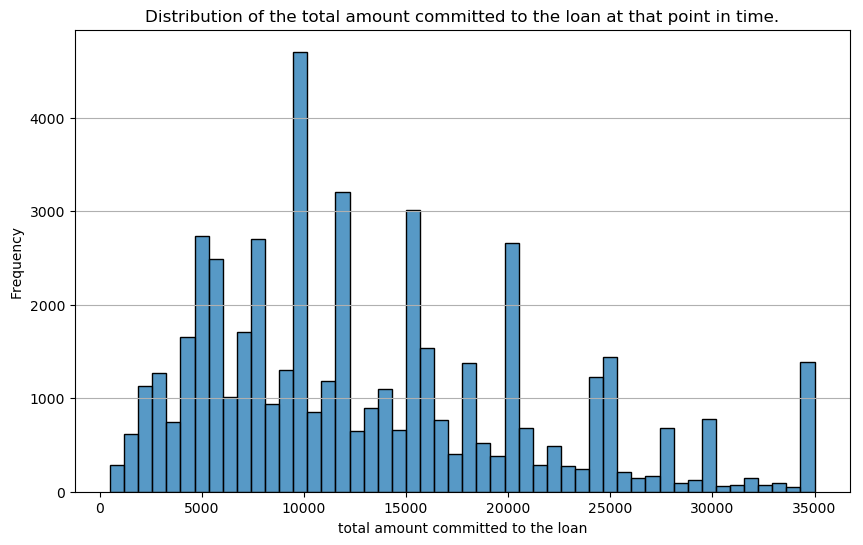

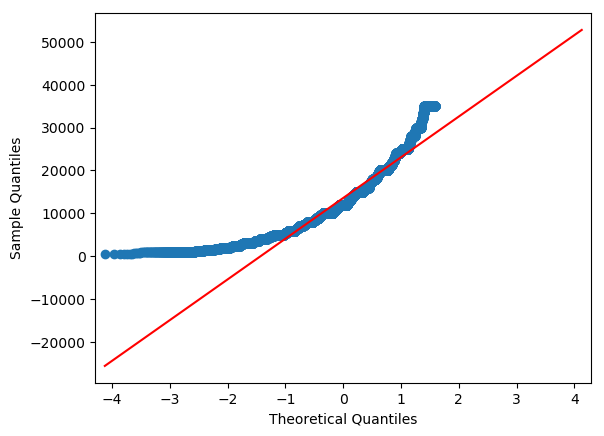

In [18]:
# Normality test
df_inf.norm_test("funded_amount")
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="funded_amount", bins= 50)
plt.title('Distribution of the total amount committed to the loan at that point in time.')
plt.xlabel('total amount committed to the loan')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()
# QQplot
qq_plot = qqplot(df_prep.dataframe["funded_amount"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.


In [19]:
# Imputing "funded_amount" using the median

# Get the mendian
df_inf.descriptive_stats(selected_column=["funded_amount"])
# replace null values
df_prep.replace_null("funded_amount", 12000.0)



 
funded_amount: 
 mean:13229.50911682024  
 median:12000.0 
 standard_deviation: 8019.01759934149


,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.000000,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.000000,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.000000,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.000000,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.000000,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.000000,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,104.942381,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.000000,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.000000,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,1,INDIVIDUAL


Statistics=16516.551, p=0.000


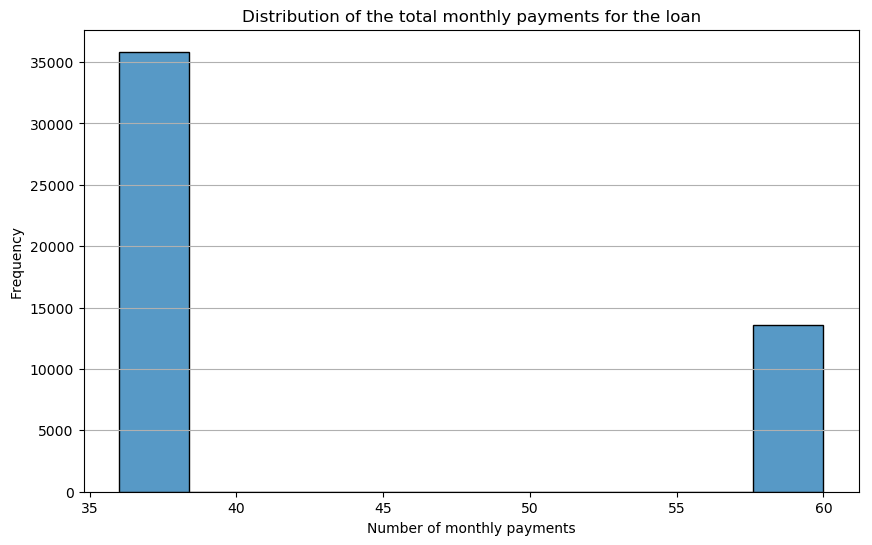

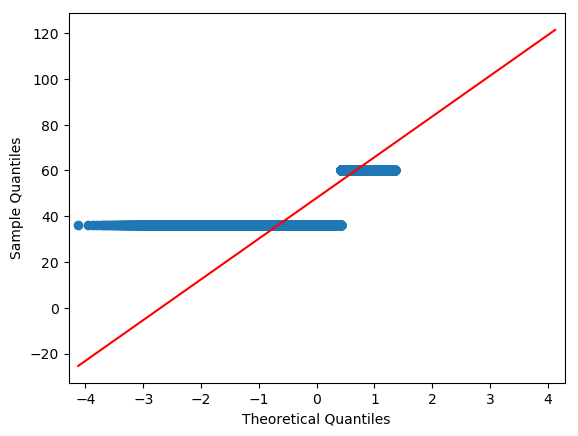

In [20]:
# Normality test
df_inf.norm_test("term_in_months")
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="term_in_months", bins= 10)
plt.title('Distribution of the total monthly payments for the loan')
plt.xlabel('Number of monthly payments')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

# QQplot
qq_plot = qqplot(df_prep.dataframe["term_in_months"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is only two values and since is categorical we impute the null values using the median. 

In [21]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats(selected_column=["term_in_months"])
# replace null values
df_prep.replace_null("term_in_months", 36.0)


 
term_in_months: 
 mean:42.60619907398047  
 median:36.0 
 standard_deviation: 10.71957251449841


,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.000000,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.000000,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.000000,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.000000,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.000000,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.000000,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,104.942381,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.000000,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.000000,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,1,INDIVIDUAL


Statistics=1421.934, p=0.000


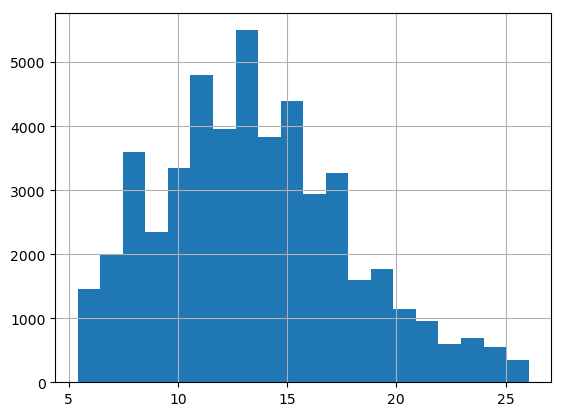

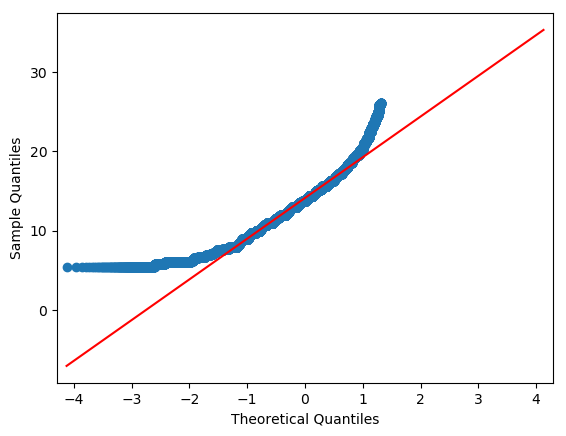

In [22]:
# Normality test
df_inf.norm_test("int_rate")
# Historgram
df_prep.dataframe["int_rate"].hist(bins=20)
# QQplot
qq_plot = qqplot(df_prep.dataframe["int_rate"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.

In [23]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats(selected_column=["int_rate"])
# replace null values
df_prep.replace_null("int_rate", 13.16)


 
int_rate: 
 mean:13.507328482327546  
 median:13.16 
 standard_deviation: 4.392892583652351


,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.000000,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.000000,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.000000,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.000000,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.000000,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.000000,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,104.942381,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.000000,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.000000,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,1,INDIVIDUAL


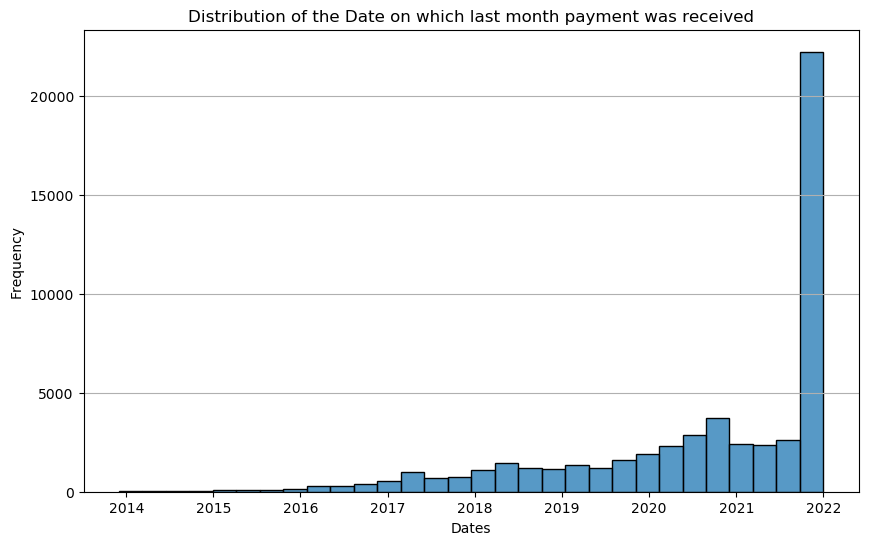

In [24]:
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="last_payment_date", bins= 30)
plt.title('Distribution of the Date on which last month payment was received')
plt.xlabel('Dates')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

The histogram showed significant skewness of the data but since the data is date type the median.

In [25]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats( selected_column=["last_payment_date"])

# replace null values
df_prep.replace_null("last_payment_date",  pd.to_datetime('2022-01-01 00:00:00'))


 
last_payment_date: 
 mean:2020-08-23 00:21:38.600391680  
 median:2021-04-01 00:00:00 
 standard_deviation: 586 days 05:22:10.970691976


,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.000000,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.000000,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.000000,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.000000,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.000000,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.000000,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,104.942381,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.000000,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.000000,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,1,INDIVIDUAL


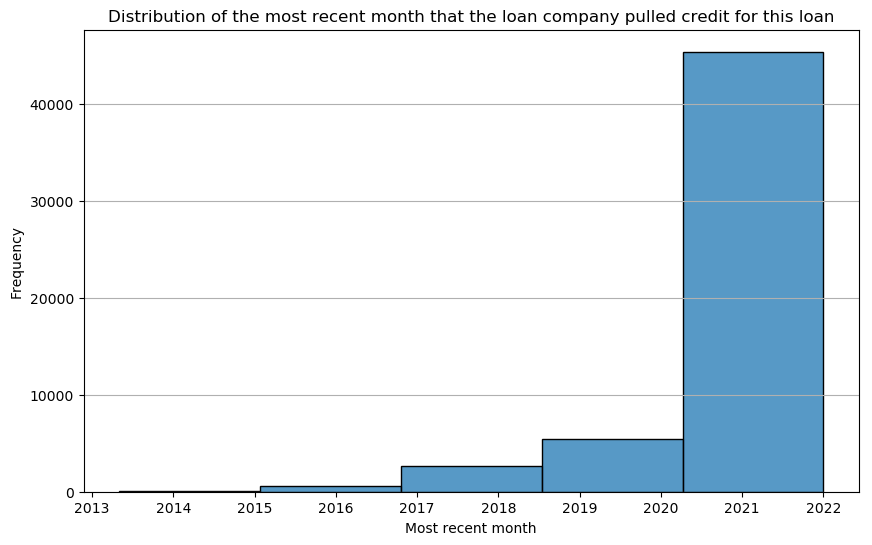

In [26]:
#Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="last_credit_pull_date", bins= 5)
plt.title('Distribution of the most recent month that the loan company pulled credit for this loan')
plt.xlabel('Most recent month')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

The histogram showed significant skewness of the data but since the data is date type the median.

In [27]:
# Impute values of the "last_payment_date column

# Get the mendian
df_inf.descriptive_stats( selected_column=["last_credit_pull_date"])

# replace null values
df_prep.replace_null("last_credit_pull_date",  pd.to_datetime('2022-01-01 00:00:00'))


 
last_credit_pull_date: 
 mean:2021-04-15 16:16:28.964296192  
 median:2022-01-01 00:00:00 
 standard_deviation: 473 days 08:18:38.512651744


,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.000000,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.000000,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.000000,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.000000,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.000000,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.000000,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,104.942381,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.000000,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.000000,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,1,INDIVIDUAL


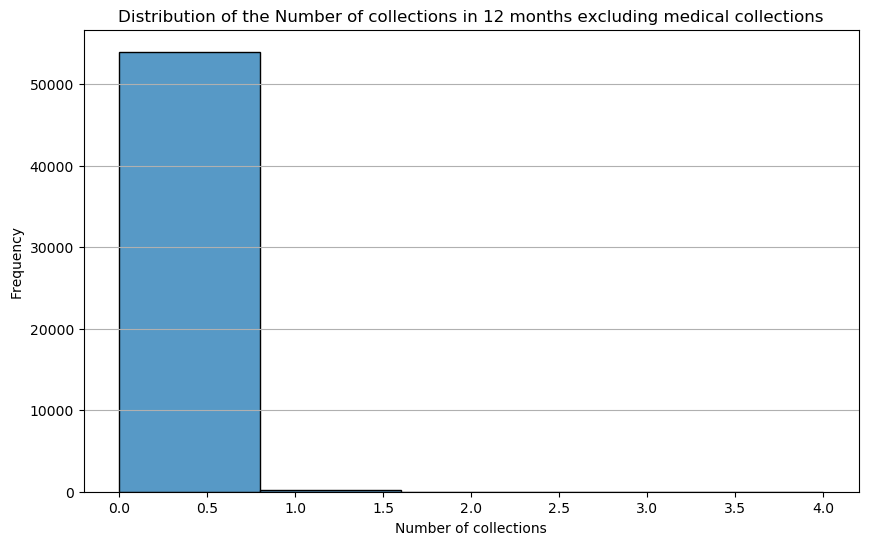

In [28]:
#Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="collections_12_mths_ex_med", bins= 5)
plt.title('Distribution of the Number of collections in 12 months excluding medical collections')
plt.xlabel('Number of collections')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

In [29]:
# Get the median
df_inf.descriptive_stats(selected_column=["collections_12_mths_ex_med"])
# replace null values
df_prep.replace_null("collections_12_mths_ex_med", 0.0)


 
collections_12_mths_ex_med: 
 mean:0.004208194905869324  
 median:0.0 
 standard_deviation: 0.0709901457713239


,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.000000,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.000000,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.000000,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.000000,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.000000,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.000000,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,0.0,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,104.942381,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.000000,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,0.0,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.000000,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,0.0,1,INDIVIDUAL


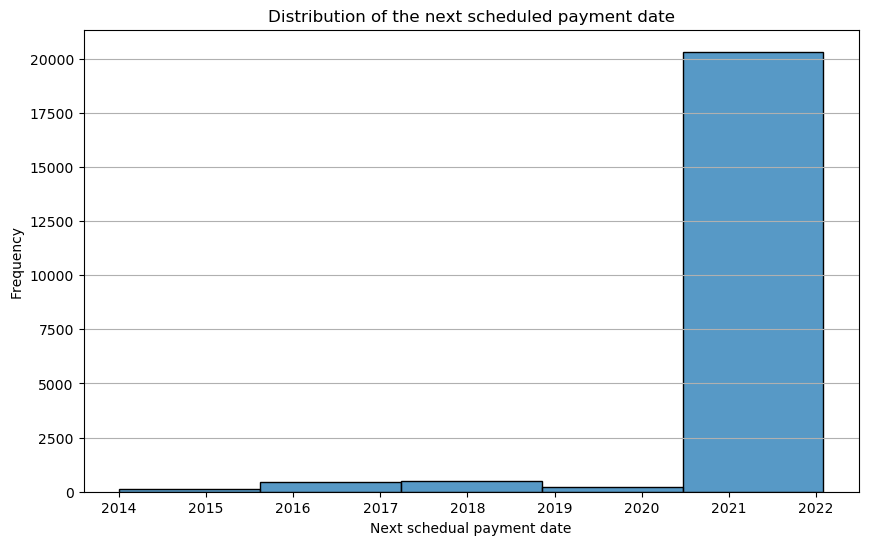

In [30]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="next_payment_date", bins= 5)
plt.title('Distribution of the next scheduled payment date')
plt.xlabel('Next schedual payment date')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

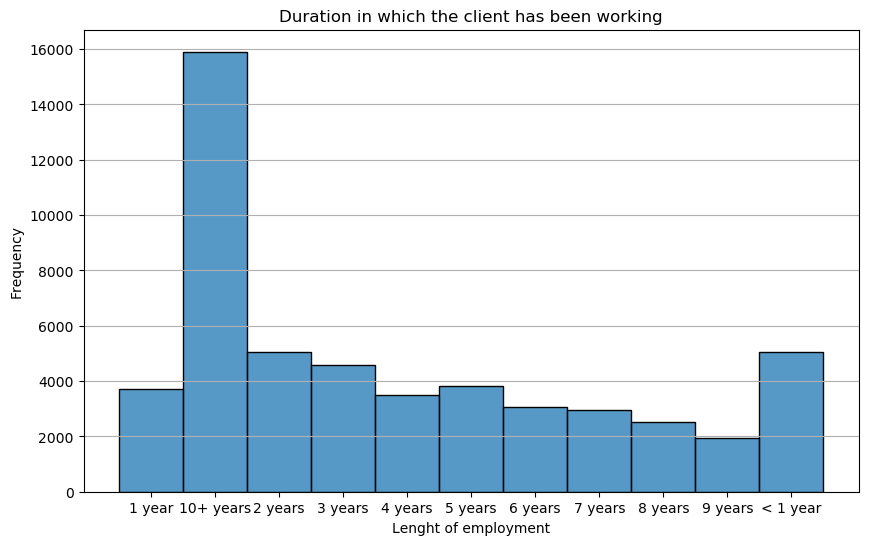

In [31]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="employment_length", bins= 5)
plt.title('Duration in which the client has been working')
plt.xlabel('Lenght of employment')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

The histogram showed skweness of the data and since it is categorical data, I will use the mode to impute the missing values.

In [32]:
# Imputing
# Get the mode
df_prep.dataframe["employment_length"].mode()
# replace null values
df_prep.replace_null("employment_length",  "10+ years")


,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.000000,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.000000,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.000000,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.000000,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.000000,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.000000,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,0.0,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,104.942381,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.000000,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,0.0,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.000000,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,0.0,1,INDIVIDUAL


In [33]:
#df = pd.read_csv("./loan_payments")

In [34]:
plots = plo.Plotter(df_prep.dataframe)


<Figure size 1200x800 with 0 Axes>

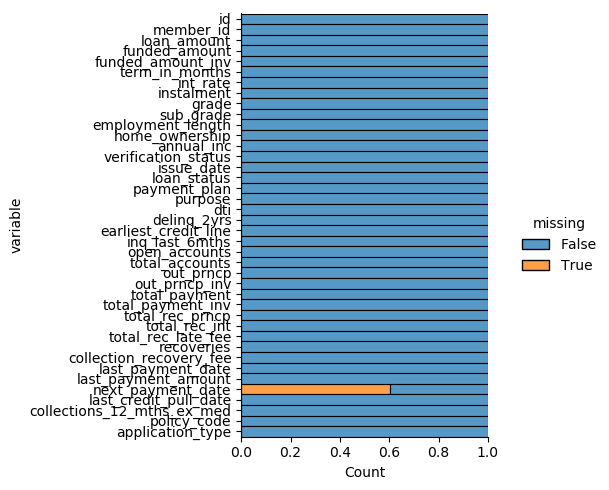

In [35]:
plots.missing_values_plot()

Now I will check the skewnessof the numeric and date type columns, wiht >= 0.5 showing skewness.

In [36]:
df_inf.skew_check()


 id: 
 skewness:2.37 


 member_id: 
 skewness:2.21 


 loan_amount: 
 skewness:0.81 


 funded_amount: 
 skewness:0.82 


 funded_amount_inv: 
 skewness:0.81 


 term_in_months: 
 skewness:1.01 


 instalment: 
 skewness:1.0 



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

These columns are skew I will proceed to transform them. All have positive skew.

loan_amount:        0.81 
funded_amount_inv:  0.81 
out_prncp:          2.36 
out_prncp_inv:      2.36
total_payment:      1.27 
total_payment_inv:  1.26 
total_rec_int:      2.2 
total_rec_late_fee: 13.18 
recoveries:         14.59 

In [ ]:
# Visualise the skew
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="loan_amount", bins= 10)
plt.title('Amount of loan the applicant received')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

From the histogram we can confirm that the data is skewed and therefore it will need to be transform. Since there are not negative number box-Cox but we can also use the log transformation. Therefore I will apply the log transformation.

In [ ]:
df_prep.dataframe["loan_amount"] 


No handles with labels found to put in legend.


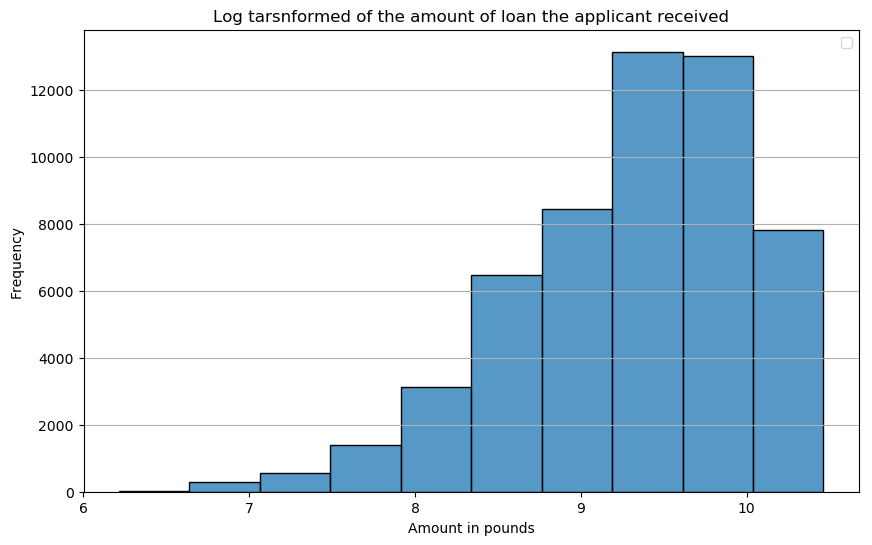

No handles with labels found to put in legend.


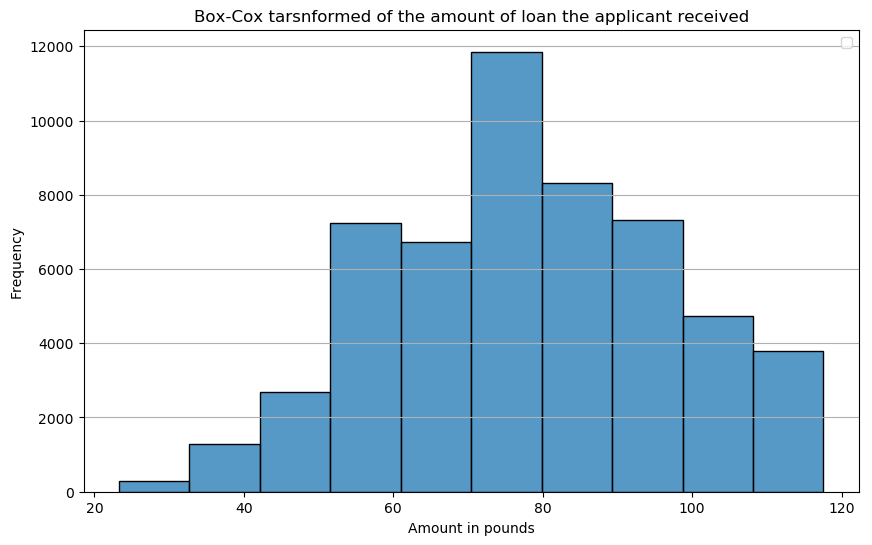

No handles with labels found to put in legend.


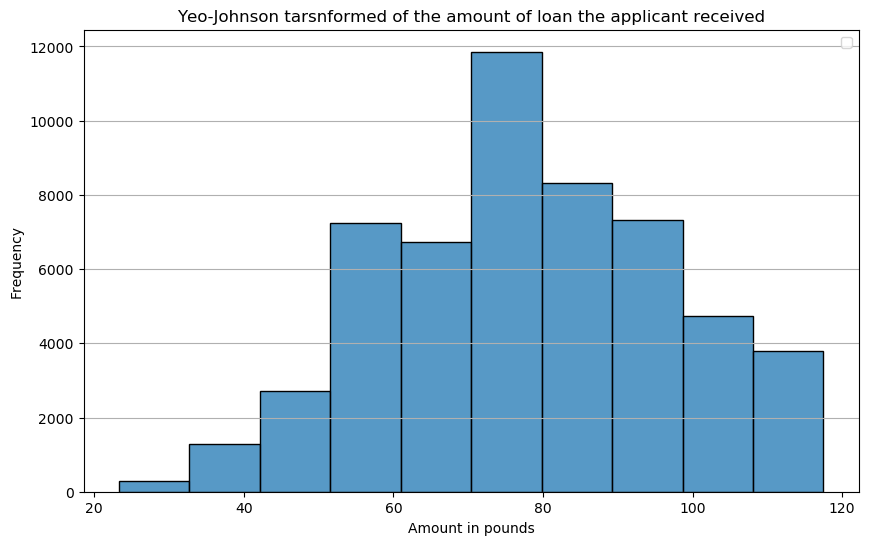

In [66]:
# Apply log transformation.
loan_skew_transform = df_prep.skew_transform(df_prep.dataframe["loan_amount"], transformation="all")


plt.figure(figsize=(10, 6))
sns.histplot(data=loan_skew_transform, x="log", bins= 10)
plt.title('Log tarsnformed of the amount of loan the applicant received')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.legend() 
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data=loan_skew_transform, x="Box-Cox", bins= 10)
plt.title('Box-Cox tarsnformed of the amount of loan the applicant received')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.legend() 
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data=loan_skew_transform, x="Yeo-Johnson", bins= 10)
plt.title('Yeo-Johnson tarsnformed of the amount of loan the applicant received')
plt.xlabel('Amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.legend() 
plt.show()



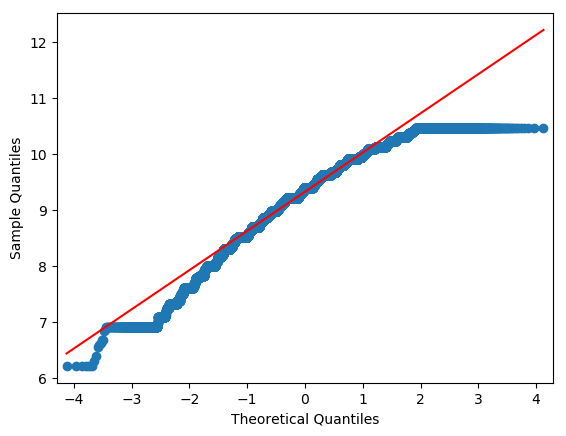

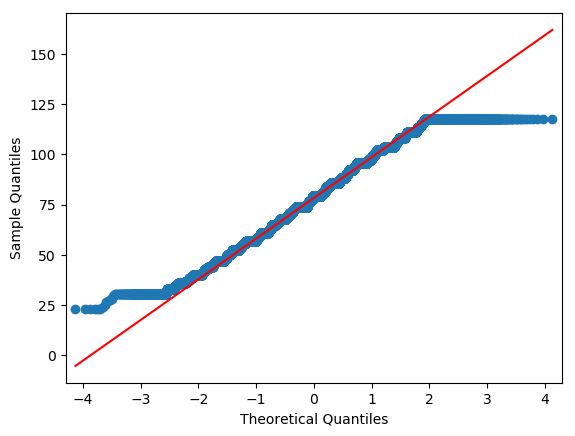

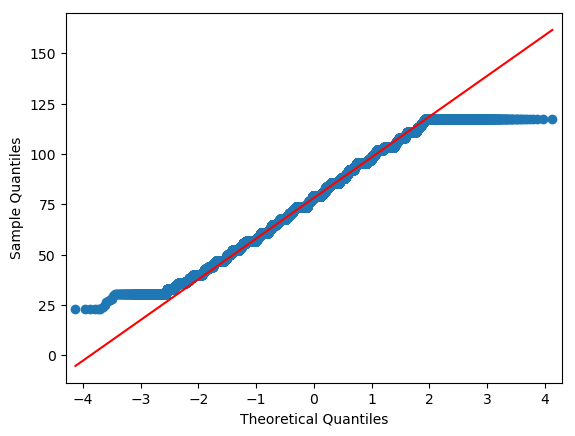

In [74]:

# QQplot
qq_plot = qqplot(loan_skew_transform["log"], scale=1 ,line='q')
qq_plot = qqplot(loan_skew_transform["Box-Cox"], scale=1 ,line='q')
qq_plot = qqplot(loan_skew_transform["Yeo-Johnson"], scale=1 ,line='q')
pyplot.show()

Based on histograms and qqplots the Box-Cox and Yeo-Johnson trasnformation produce the greater effect. Since  all the data in the column is positive the will proceed wiht Box-Cox transformation.

In [75]:
df_prep.dataframe["loan_amount"] = df_prep.skew_transform(df_prep.dataframe["loan_amount"], transformation="BC")

        

0         8000
1        13200
2        16000
3        15000
4        15000
         ...  
54226     5000
54227     5000
54228     3500
54229     5000
54230     5000
Name: loan_amount, Length: 54231, dtype: int64

In [76]:
df_prep.dataframe["loan_amount"] = df_prep.skew_transform(df_prep.dataframe["loan_amount"], transformation="BC")


0        67.94
1        81.92
2        88.00
3        85.91
4        85.91
         ...  
54226    56.93
54227    56.93
54228    49.73
54229    56.93
54230    56.93
Name: loan_amount, Length: 54231, dtype: float64

plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="loan_amount", bins= 10)
plt.title('Distribution of log transformed amount of loan the applicant received')
plt.xlabel('log amount in pounds')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()